# Set up Environment

In [1]:
# Import Packages
import os
from pathlib import Path
import re
import glob

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import shutil
import itertools

import nilearn
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn import plotting, datasets
from collections import defaultdict

import nibabel as nib
import nibabel.processing

#!pip install fslpy
import fsl
from fsl.wrappers import bet
import subprocess


# Preprocessed Image Directories

In [2]:
preprocessed_test_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/test"
preprocessed_train_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/train"
preprocessed_val_dir = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/val"

# Check for All 0 Images
### Expected: None
### Found: None

In [ ]:
def check_zero_images(folder_path):
    zero_images = []
    
    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        
        # Ensure it's a file
        if os.path.isfile(file_path):
            try:
                # Load the image
                img = load_img(file_path)
                
                # Get the tensor values
                data = img.get_fdata()
                
                # Check if all values are zero
                if np.all(data == 0):
                    zero_images.append(file_name)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    if zero_images:
        print("Images that contain only 0s:")
        for img_name in zero_images:
            print(img_name)
    else:
        print("No images contain only 0s.")

# Usage
check_zero_images(preprocessed_test_dir)
check_zero_images(preprocessed_train_dir)
check_zero_images(preprocessed_val_dir)

# Check for Voxel Sizes and Overall Image Dimensions
### Expected: Voxel Sizes 1.5 ^3 , Image Sizes 256 ^3
### Found: Voxel Sizes 1.5 ^3 , Image Sizes 256 ^3

In [ ]:
def get_unique_image_shapes_and_voxels(folder_path):
    unique_shapes = set()
    unique_pixel_dims = set()
    non_standard_files = []  # Store filenames that don't match criteria
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        try:
            img = nib.load(file_path)
            if img is not None:
                # Convert values to standard Python integers
                dimensions = [float(x) for x in img.shape]
                voxel_size = [float(x) for x in img.header.get_zooms()]
                
                unique_shapes.add(tuple(dimensions))  
                unique_pixel_dims.add(tuple(voxel_size)) 

                # Check if shape or voxel size is not [256,256,256] or [1,1,1]
                if dimensions != [1.0, 256.0, 256.0, 256.0] or voxel_size != [1.5, 1.5, 1.5, 1.0]:
                    non_standard_files.append(filename)
                    
        except Exception as e:
            print(f"Skipping {filename}: {e}")
    
    # Convert back to list of lists for the final output
    return (
        [list(shape) for shape in unique_shapes], 
        [list(pixel) for pixel in unique_pixel_dims], 
        non_standard_files
    )

# Usage
shapes, pixels, non_standard_files = get_unique_image_shapes_and_voxels(preprocessed_test_dir)
print("Unique image shapes in test set:", shapes)
print("Unique pixel dimensions in test set:", pixels)
print("Files with non-standard shapes or pixels:", non_standard_files)
print("Number of files with non-standard shapes or pixels:", len(non_standard_files))

shapes, pixels, non_standard_files = get_unique_image_shapes_and_voxels(preprocessed_train_dir)
print("Unique image shapes in train set:", shapes)
print("Unique pixel dimensions in train set:", pixels)
print("Files with non-standard shapes or pixels:", non_standard_files)
print("Number of files with non-standard shapes or pixels:", len(non_standard_files))

shapes, pixels, non_standard_files = get_unique_image_shapes_and_voxels(preprocessed_val_dir)
print("Unique image shapes in val set:", shapes)
print("Unique pixel dimensions in val set:", pixels)
print("Files with non-standard shapes or pixels:", non_standard_files)
print("Number of files with non-standard shapes or pixels:", len(non_standard_files))

# Check for Range of Pixel Values/Voxel Intensitites
### Expected: [0-1]
### Found: Z-Score Normalized Values - expect relu to treat negatives as 0s
#### Notes: Best practive would be to figure out how the pretrained model preprocessed their intensities and copy that however, they don't explicitly state anywhere how but z-normalization is standard practice for this data type

In [5]:
image_path = Path.cwd() / "Preprocessed_Data/ABIDE_COMBINED/test/29864_prep.nii.gz"

img = nilearn.image.load_img(image_path)

test = img.get_fdata()

print(test.min())
print(test.max())

-0.4349769651889801
3.623023509979248


In [6]:
np.squeeze(test[:,:,:,:])[125][125] #middle slice

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.43497697, -0.43497697, -0.43497697, -0.43497697,
       -0.43497697, -0.43497697, -0.43497697, -0.43497697, -0.43497697,
       -0.43497697, -0.43497697, -0.43497697, -0.43497697, -0.43497697,
       -0.43497697, -0.43497697, -0.43497697, -0.43497697, -0.43

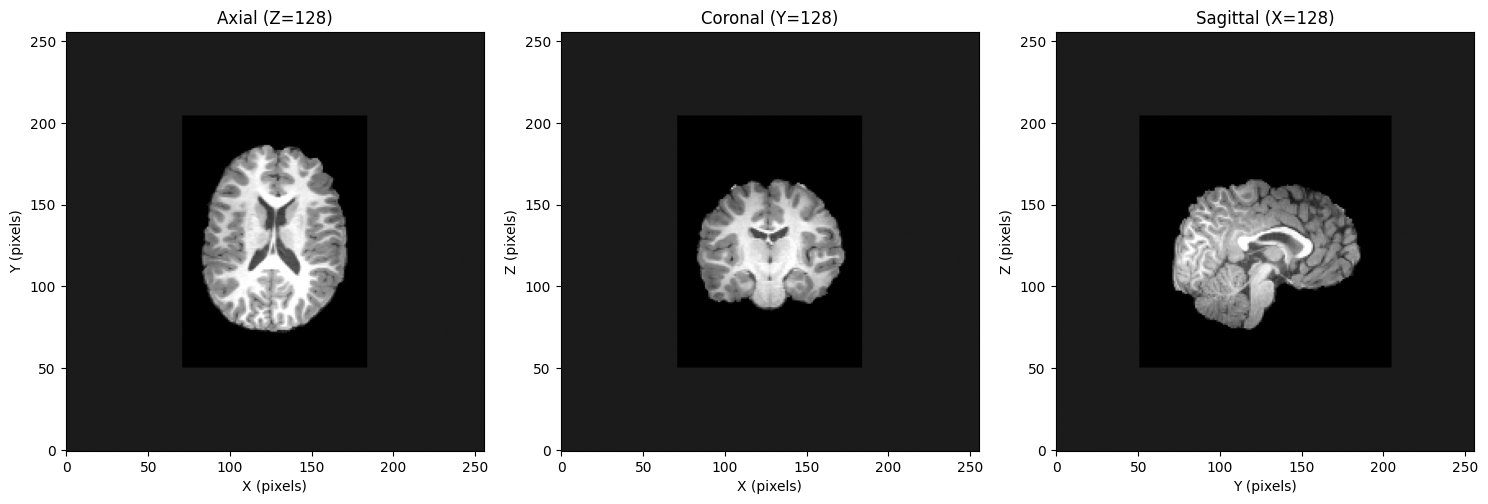

In [21]:
# Load and squeeze the image
img = nib.load(image_path)
data = np.squeeze(img.get_fdata())  # shape: (256, 256, 256)

# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()

In [23]:
#import nilearn.image

def find_overall_min_max(folder_path):
    folder = Path(folder_path)
    overall_min = float('inf')
    overall_max = float('-inf')

    for image_path in folder.glob('*.nii*'):  # matches .nii and .nii.gz
        try:
            img = nilearn.image.load_img(image_path)
            data = img.get_fdata()

            img_min = data.min()
            img_max = data.max()

            if img_min < overall_min:
                overall_min = img_min
            if img_max > overall_max:
                overall_max = img_max

            #print(f"{image_path.name}: min={img_min}, max={img_max}")

        except Exception as e:
            print(f"Error loading {image_path.name}: {e}")

    print("\nOverall min intensity:", overall_min)
    print("Overall max intensity:", overall_max)


# Usage:
find_overall_min_max(preprocessed_test_dir)
find_overall_min_max(preprocessed_train_dir)
find_overall_min_max(preprocessed_val_dir)


Overall min intensity: -0.4462190270423889
Overall max intensity: 5.015129089355469

Overall min intensity: -0.5953314900398254
Overall max intensity: 5.587343692779541

Overall min intensity: -0.4759272038936615
Overall max intensity: 5.389416694641113


#### Could start by converting all pixels under 0 to 0 (as done by relu anyways) and the negatives are just the non-brain space anyways

#### Could also (or additionally) just crop all slices (from any view) that contain pixel values all <= 0

# Results: The Images are being processed as expected
### Further Issues: There are too many 0 pixels and full 0 slices and the padding is of a different intensity than the background (due to the negative values counting as the non-brain space)

In [ ]:
def crop_positive_planes(img):
    data = np.squeeze(img.get_fdata())

    # Get boolean masks for each axis where any value is > 0
    positive_x = np.any(data > 0, axis=(1, 2))  # check each X slice
    positive_y = np.any(data > 0, axis=(0, 2))  # check each Y slice
    positive_z = np.any(data > 0, axis=(0, 1))  # check each Z slice

    # Get index ranges where values are > 0
    x_min, x_max = np.where(positive_x)[0][[0, -1]]
    y_min, y_max = np.where(positive_y)[0][[0, -1]]
    z_min, z_max = np.where(positive_z)[0][[0, -1]]

    # Crop data
    cropped_data = data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]

    # Create new image with same affine and header
    cropped_img = nib.Nifti1Image(cropped_data, affine=img.affine, header=img.header)
    
    return cropped_img

(93, 117, 95)
Axial shape: (93, 117)
Coronal shape: (93, 95)
Sagittal shape: (117, 95)


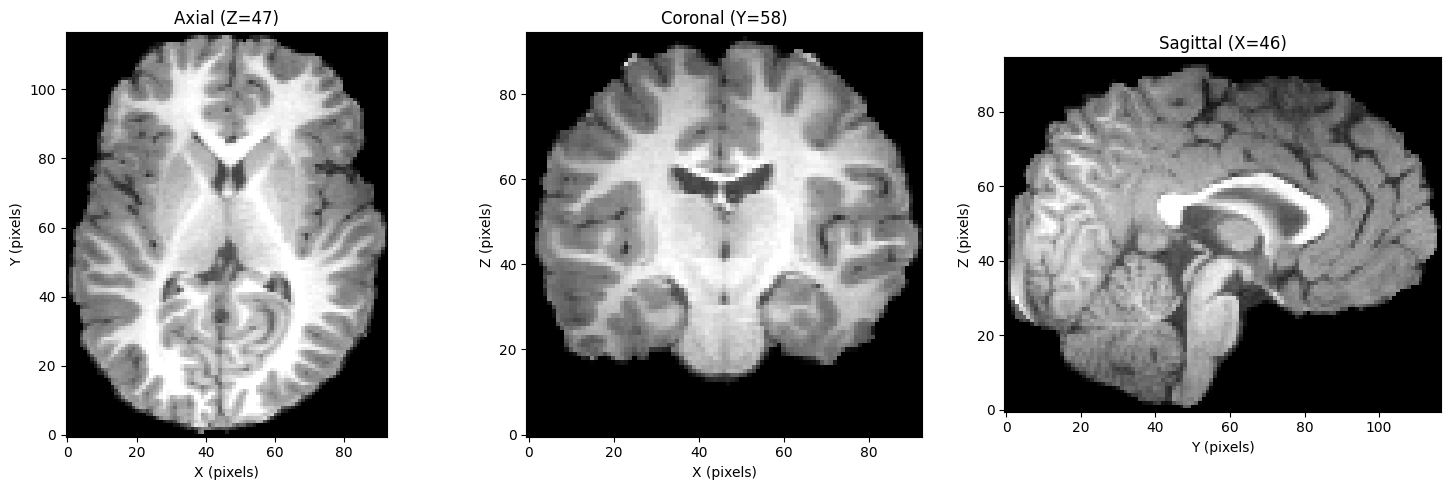

In [17]:
# Usage
img = nib.load(image_path)
img = crop_positive_planes(img)
data = np.squeeze(img.get_fdata())

print(data.shape)

# Visualize
# Select middle slices for axial, coronal, and sagittal views
mid_x = data.shape[0] // 2
mid_y = data.shape[1] // 2
mid_z = data.shape[2] // 2

print("Axial shape:", data[:, :, mid_z].shape)
print("Coronal shape:", data[:, mid_y, :].shape)
print("Sagittal shape:", data[mid_x, :, :].shape)

# Plot using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (Z slice)
axes[0].imshow(data[:, :, mid_z].T, cmap='gray', origin='lower')
axes[0].set_title(f'Axial (Z={mid_z})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')

# Coronal (Y slice)
axes[1].imshow(data[:, mid_y, :].T, cmap='gray', origin='lower')
axes[1].set_title(f'Coronal (Y={mid_y})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Z (pixels)')

# Sagittal (X slice)
axes[2].imshow(data[mid_x, :, :].T, cmap='gray', origin='lower')
axes[2].set_title(f'Sagittal (X={mid_x})')
axes[2].set_xlabel('Y (pixels)')
axes[2].set_ylabel('Z (pixels)')

plt.tight_layout()
plt.show()

In [20]:
def find_max_cropped_dimensions(folder_path):
    max_x = max_y = max_z = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".nii") or filename.endswith(".nii.gz"):
            image_path = os.path.join(folder_path, filename)
            try:
                img = nib.load(image_path)
                cropped_img = crop_positive_planes(img)
                data = np.squeeze(cropped_img.get_fdata())
                shape = data.shape

                # Update max dimensions
                max_x = max(max_x, shape[0])
                max_y = max(max_y, shape[1])
                max_z = max(max_z, shape[2])

                #print(f"{filename} cropped shape: {shape}")

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    print("\n=== Overall Max Cropped Dimensions ===")
    print(f"Max X: {max_x}")
    print(f"Max Y: {max_y}")
    print(f"Max Z: {max_z}")

# Usage
find_max_cropped_dimensions(preprocessed_test_dir)
find_max_cropped_dimensions(preprocessed_train_dir)
find_max_cropped_dimensions(preprocessed_val_dir)


=== Overall Max Cropped Dimensions ===
Max X: 104
Max Y: 129
Max Z: 124

=== Overall Max Cropped Dimensions ===
Max X: 117
Max Y: 154
Max Z: 154

=== Overall Max Cropped Dimensions ===
Max X: 110
Max Y: 132
Max Z: 154


In [ ]:
# Maximum Theoretical 3D Image Size: 117, 154, 154
### Could try to crop/pad everything to 128^3
### Could try taking the middle 32 or 64 images (and still copping/padding to 128^3)

# Takeaways from EDA on the Preprocessed Images:
- No fully 0 images were found (working as expected)
- All Voxel Sizes 1.5 ^3 and all Image Sizes 256 ^3 (working as expected)
- Voxel Intensities are Z-Normalized - therefore leading to negative values (which go to 0 with relu and are the non-brain space pixels anyways). There is no documentation on if the brain images used to train the pretrained model were normalized [0,1] or z-normalized but the standard for mri data is z-normalization so we will assume this. The minimum intensity is -0.60 and the maximum intensity is 5.59. The ranges are similar across train/test/val images. Conversion of all pixel values < 0 to 0 may be useful and make sense in context of the images.
- The Maximum Theoretical 3D Image Size of actual brain pixels is: 117, 154, 154, therefore cropping/padding all images to the reduced image size of 128^3 instead of 256^3 makes sense. The maxes are similar across train/test/val images.
  
# Next Steps:
- First I will crop/pad all images to size 128^3 and convert all pixel values < 0 to 0.
- If this does not solve the issues in our fine-tuning I will then try training on only the middle 32 or 64 slices.